In [1]:
import numpy as np
from itertools import combinations
import bisect
import random
import timeit
import math
import matplotlib.pyplot as plt
import decimal
from scipy.special import lambertw
from sortedcontainers import SortedList
try:
    from math import inf
except:
    inf = float('inf')
import decimal
import mpmath
from matplotlib import pyplot

In [2]:
######################################################################################################################
'''
BANDWIDTH CALCULATION ALGORITHM:
'''
def circ_bws(circ_list, bw):
    '''
    Compute the bandwidth allocated to each circuit in a list according to the max-min fairness algorithm.
    - `circ_list`: a list of circuits, each consisting of 1 or more relay indices 
    - `bw`: the amount of bandwidth that each relay has
    
    Returns a list of bandwidth that corresponds to each circuit in the list
    '''
    M_i = [set() for i in range(len(bw))]

    bw_alloc = np.zeros(len(circ_list),dtype=np.dtype(decimal.Decimal))

    for k, circ in enumerate(circ_list):
        for i in circ:
            M_i[i].add(k)

    left_bw = np.array(bw,dtype=np.dtype(decimal.Decimal))

    bw_array = [[M_i[i] and decimal.Decimal(left_bw[i] / len(M_i[i])) or inf, i] for i in range(len(left_bw))]
    bw_list = SortedList(x for x in bw_array if x[0] < inf)
    while any(M_i):
        bn_bw, bn_relay = bw_list.pop(0)
        update_relays = set()
        for k in M_i[bn_relay]:
            bw_alloc[k] = decimal.Decimal(bn_bw)
            for j in circ_list[k]:
                if j != bn_relay:
                    update_relays.add(j)
                    left_bw[j]=decimal.Decimal(decimal.Decimal(left_bw[j])-decimal.Decimal(bn_bw))
                    M_i[j].remove(k)
        M_i[bn_relay] = set()
        left_bw[bn_relay] = 0
        for i in update_relays:
            bw_list.remove(bw_array[i])
            if M_i[i]:
                bw_array[i][0] = decimal.Decimal(left_bw[i] / len(M_i[i]))
                bw_list.add(bw_array[i])

    return bw_alloc
##########################################################################################################################


##########################################################################################################################
'''
IMPORT VALUES USED AS CAPACITIES GROUND TRUTH:
'''


import json
with open('tor-consensus-with-observed-weights-2021-04-30.json') as fp:
    data = json.load(fp)
    
bwguard=data['guards']
bwmiddle=data['middles']
bwexit=data['exits']

bwguard=sorted(bwguard)  #relays that can be used in the first position (as well as in the second position as explained in paper)            
bwmiddle=sorted(bwmiddle)     #relays that can only be used in second position           
bwexit=sorted(bwexit)    #relays that can only be used in third position
#########################################################################################################################

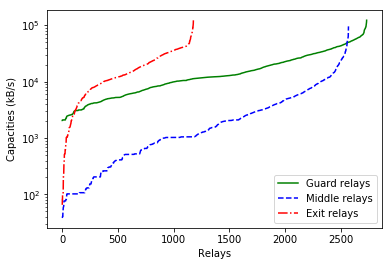

In [90]:
from matplotlib import pyplot
plt.plot(np.array(bwguard)/1000, label="Guard relays", color='g')
plt.plot(np.array(bwmiddle)/1000, label="Middle relays", linestyle='--', color='b')
plt.plot(np.array(bwexit)/1000, 'r',label="Exit relays", linestyle='-.')
pyplot.yscale('log')
plt.xlabel('Relays')
plt.ylabel('Capacities (kB/s)')
plt.legend()

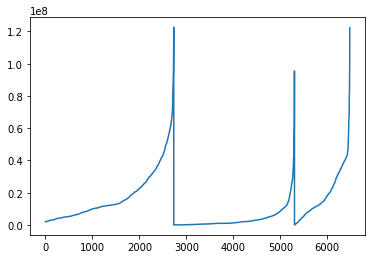

In [4]:
##################################################################################################################
'''
Concatenation of the whole capacities vectors to create one vector 'bw' containing all relays in the network:
'''

bw=np.zeros(len(bwguard)+len(bwmiddle)+len(bwexit))
for i in range(len(bwguard)):
    bw[i]=bwguard[i]
for i in range(len(bwmiddle)):
    bw[i+len(bwguard)]=bwmiddle[i]
for i in range(len(bwexit)):
    bw[i+len(bwguard)+len(bwmiddle)]=bwexit[i]

plt.plot(bw)
###################################################################################################################

In [5]:
#######################################################################################################################
'''
CREATING A VECTOR FOR RELAYS THAT CAN BE USED IN SECOND POSITION:
As explained in the paper guards relays can also be used in the second position.
Create a new vector bwmiddle2 that contains all relays that can be used in second position, i.e. 'middle relays' and 'factor * guard relays'.
For the rest of the code: every vector with '2' after middle refers to all the relays that can be used in the second position.
'''
bwmiddle2=np.zeros(len(bwguard)+len(bwmiddle))
for i in range(len(bwguard)):
    bwmiddle2[i]=0.42*bwguard[i] #for our case we calculated the factor from the actual capacities we are using
for i in range(len(bwmiddle)):
    bwmiddle2[i+len(bwguard)]=bwmiddle[i]
#######################################################################################################################

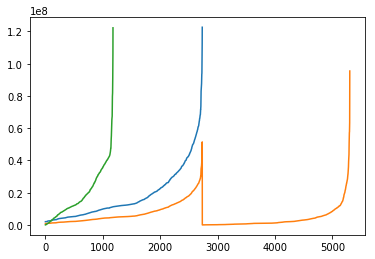

In [6]:
plt.plot(bwguard)
plt.plot(bwmiddle2)
plt.plot(bwexit)

In [7]:
################################################################################################################
'''
Path generating algorithms:
'''
def cum_density(c):
    '''
    Input: `c` weights vector
    Return: cumulutive density of weight vector
    '''
    cumbw = np.cumsum(c).astype(float)
    return cumbw / np.sum(c)

def rand_relay(c):
    '''
    Input: `c` weights vector
    Return: a relay chosen randomly weighted by the weights vector
    '''
    x = random.random()
    return bisect.bisect_right(cum_density(c), x)


def P_onerelay(bw, N):
    '''
    Input: - `bw`: the amount of bandwidth that each relay has
            - `N` : number of path to generate
    Return: `N` paths of one relay
    '''
    network=[]
    circ_len=1 #number of relays in each path
    for i in range(N): 
         while True:
            circuit=set()
            circuit.add(rand_relay(bw))
            if len(circuit) == circ_len:
                network.append(circuit)
                break
    return network    

def P_threerelays(bwguard, bwmiddle2, bwexit, N):
    '''
    Input: - `bwguard`: the amount of bandwidth that each relay that can be placed in the first position has
            - `bwmiddle2`: the amount of bandwidth that each relay that can be placed in the second position has
            - `bwexit`: the amount of bandwidth that each relay that can be placed in the third position has
            - `N` : number of paths to generate
    Return: `N` paths of one relay
    '''
    network=[]
    circ_len=3
    for i in range(N): 
        while True:
            circuit=set()
            circuit.add(rand_relay(bwguard))
            circuit.add(rand_relay(bwmiddle2))
            circuit.add(rand_relay(bwexit)+len(bwmiddle2))
            if len(circuit) == circ_len:
                network.append(circuit)
                break
    return network
#############################################################################################################

In [8]:
'''
for one relay network observation:
'''
# 1) with no noise:
def O(network,bw): 
    '''
    Input: - the network of single relay paths
            - `bw`:the amount of bandwidth that each relay has
    Return: bandwidth of the observation `m_t[i]` probe of each relay 
    '''
    for i in range(len(bw)):
        network.append({i})
    bw_alloc=circ_bws(network,bw)

    return np.array(bw_alloc[(len(network)-len(bw)):],dtype=np.dtype(float))


# 2) with noise:
def O_noise(network, bw):
    '''
    Input: - the network of single relay paths
            - `bw`:the amount of bandwidth that each relay has
    Return: bandwidth of the observation `m_t[i]` probe of each relay 
    '''    
    obs=O(network,bw)
    for i in range(len(bw)):
        y=np.random.normal(1,0.5)
        while y<0.7 or y>1.3:
            y=np.random.normal(1,0.5)
        obs[i]=obs[i]*y
    return obs

In [9]:
'''
for three relays network observation: (notice we use bwmiddle and not bwmiddle2)
'''
# 1) with no noise:
def Ospec(network, bw, bwguard, bwmiddle, bwexit):
    
    Oguard=np.zeros(len(bwguard))
    Omiddle=np.zeros(len(bwmiddle))
    Oexit=np.zeros(len(bwexit))
        
    obs=O(network,bw)
    for i in range(len(bwguard)):
        Oguard[i]=obs[i]
    for i in range(len(bwmiddle)):
        Omiddle[i]=obs[i+len(bwguard)]
    for i in range(len(bwexit)):
        Oexit[i]=obs[i+len(bwguard)+len(bwmiddle)]
    return [Oguard, Omiddle, Oexit]

# 2) with noise:
def Ospec_noise(network, bw, bwguard, bwmiddle, bwexit):
    
    Oguard=np.zeros(len(bwguard))
    Omiddle=np.zeros(len(bwmiddle))
    Oexit=np.zeros(len(bwexit))
        
    obs=O(network,bw)
    for i in range(len(bwguard)):
        y=np.random.normal(1,0.5)
        while y<0.7 or y>1.3:
            y=np.random.normal(1,0.5)
        Oguard[i]=obs[i]*y
    for i in range(len(bwmiddle)):
        y=np.random.normal(1,0.5)
        while y<0.7 or y>1.3:
            y=np.random.normal(1,0.5)
        Omiddle[i]=obs[i+len(bwguard)]*y
    for i in range(len(bwexit)):
        y=np.random.normal(1,0.5)
        while y<0.7 or y>1.3:
            y=np.random.normal(1,0.5)
        Oexit[i]=obs[i+len(bwguard)+len(bwmiddle)]*y
    return [Oguard, Omiddle, Oexit]

In [10]:
# Generate one relay paths:
def generate_one_relay(lambdas,bw):
    circofone=P_onerelay(bw,lambdas)
    return circofone

def generate (lambdas,bwguard, bwmiddle2, bwexit):
    circofone=P_threerelays(bwguard,bwmiddle2,bwexit,lambdas)
    return circofone

In [11]:
cguard=np.zeros(len(bwguard))
l=sum(bwguard)
for i in range(len(bwguard)):
    cguard[i]=bwguard[i]/l
    
cmiddle=np.zeros(len(bwmiddle))
l=sum(bwmiddle)
for i in range(len(bwmiddle)):
    cmiddle[i]=bwmiddle[i]/l
    
cmiddle2=np.zeros(len(bwmiddle2))
l=sum(bwmiddle2)
for i in range(len(bwmiddle2)):
    cmiddle2[i]=bwmiddle2[i]/l

cexit=np.zeros(len(bwexit))
l=sum(bwexit)
for i in range(len(bwexit)):
    cexit[i]=bwexit[i]/l
    
c=np.zeros(len(bw))
l=sum(bw)
for i in range(len(bw)):
    c[i]=bw[i]/l

In [12]:
def logfac(x):
    logfact=np.zeros(x+1)
    logfact[0]=0
    for i in range(len(logfact)-1):
        logfact[i+1]=logfact[i]+math.log(i+1)
    return logfact

def logsumcal(c,B,Q):
    L=B-0.5*pow((Q*(1/c)-1)/0.5,2)
    xmax=len(B)-1
    L.sort()
    resI=L[xmax]
    L=L-resI
    L=np.exp(L)
    L=L[:xmax]
    res=sum(L)
    res=resI+math.log(1+res)
    return res

def quant(bw,z):
#     minimum=min(bw)-z/2
    minimum=0
    Cls=[]
    L=[]
    m=int(math.ceil(math.log(max(bw)-minimum)/math.log(z)))
    index=np.zeros(len(bw))
    bw2=np.zeros(len(bw))
    RCl = [set() for i in range(m)]
    for i in range(len(bw)):
        for j in range(m):
            if bw[i]<=(minimum+pow(z,j+1)):
                index[i]=j+1
                #always set the minimum bandwidth to 1
                if j==0:
                    bw2[i]=1
                else:
                    bw2[i]=(2*minimum+pow(z,j+1)+pow(z,j))/2
                RCl[j].add(i)
                break
    for j in range(m):
        if j==0:
            Cls.append(1)
#             Cls.append(minimum)
        else:
            Cls.append((2*minimum+pow(z,j+1)+pow(z,j))/2)
        L.append(len(RCl[j]))
    return m,bw2, index, RCl, Cls, L

[m,bw2, index, RCl, Cls,L]= quant(bw,1.1)

In [13]:
m

196

Text(0,0.5,'Error')

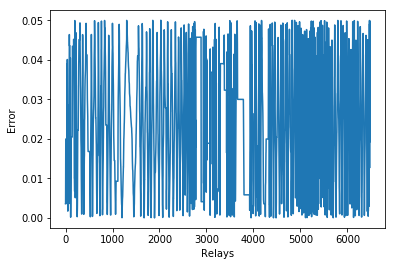

In [14]:
plt.plot(abs(bw-bw2)/bw)
plt.xlabel('Relays')
plt.ylabel('Error')

In [15]:
#######################################################################################################################
                                                        '''
                                                START OF THE ALGORITHMS
                                                        '''
#######################################################################################################################

In [16]:
def torflow_onerelay (lambdas,t,w0, bw, noise):# noise=0 for non noisy and =1 for noise
    
    if noise==0:
        exptor=[[] for i in range(len(bw))]
        vartor=[[] for i in range(len(bw))]
        wd=[[] for i in range(len(bw))]
    
    C=np.zeros(len(bw))
   
    w=np.zeros(len(bw))
    for i in range(len(bw)):
        w[i]=w0[i]
    l=sum(w)
    for i in range(len(w)):
        w[i]=w[i]/l
    
  
    for q in range (t):
        circofone=P_onerelay(w,lambdas)
        if noise==0:
            o=O(circofone,bw)
        else:
            o=O_noise(circofone,bw)
        av=sum(o)/len(o)
        for i in range(len(bw)):
            if noise==0:
                exptor[i]=np.append(exptor[i],bw[i]*(1-math.exp(-lambdas*w[i])))
                vartor[i]=np.append(vartor[i],(bw[i]**2)*((lambdas*w[i])**3)/((lambdas*w[i]+1)**4))
            w[i]=w[i] * o[i] / av
        l=sum(w)
        for i in range(len(bw)):
            w[i]=w[i]/l
            if noise==0:
                wd[i]=np.append(wd[i],w[i])
    if noise==0:    
        return [w, wd, exptor, vartor]
    else:
        return [w]

In [17]:
w0=np.zeros(len(bw))
for i in range(len(bw)):
    w0[i]=1/len(bw)
    
wtorflow_onerelay_nn_50 =torflow_onerelay(1000000,50,w0,bw,0)

In [18]:
var_torflow=wtorflow_onerelay_nn_50[3]

In [19]:
circuit_torflow_onerelay_nn=generate_one_relay(1000000,wtorflow_onerelay_nn_50[0])
bandwidth_torflow_onerelay_nn=circ_bws(circuit_torflow_onerelay_nn,bw)

In [20]:
w0=np.zeros(len(bw))
for i in range(len(bw)):
    w0[i]=1/len(bw)
    
wtorflow_onerelay_50 =torflow_onerelay(1000000,50,w0,bw,1)

In [21]:
circuit_torflow_onerelay_noise=generate_one_relay(1000000,wtorflow_onerelay_50[0])
bandwidth_torflow_onerelay_noise=circ_bws(circuit_torflow_onerelay_noise,bw)

In [70]:
error_r_tor=np.zeros(len(bw))
for i in range(len(error_r_tor)):
    error_r_tor[i]=abs(wtorflow_onerelay_nn_50[0][i]-c[i])/c[i]*100

In [71]:
error_r_tor_n=np.zeros(len(bw))
for i in range(len(error_r_tor_n)):
    error_r_tor_n[i]=abs(wtorflow_onerelay_50[0][i]-c[i])/c[i]*100

In [24]:
def stochasticpoisson_onerelay(lambdas,t,w0,cqm, bw, noise, min_noise, max_noise):  #min and max noise when applicable, else just enter zero in the case of no noise  
    if noise==0:
        expmle2=[[] for i in range(len(bw))]
        varmle=[[] for i in range(len(bw))]

        nue1=np.zeros(len(bw),dtype=np.dtype(decimal.Decimal))
        nue2=np.zeros(len(bw),dtype=np.dtype(decimal.Decimal))
        sigma1=np.zeros(len(bw),dtype=np.dtype(decimal.Decimal))
        sigma2=np.zeros(len(bw),dtype=np.dtype(decimal.Decimal))

        wd=[[] for i in range(len(bw))]


        LF=logfac(lambdas)

        Logm=np.zeros((len(bw), len(cqm)))
        C=np.zeros(len(bw))


        w=np.zeros(len(bw))
        for i in range(len(bw)):
            w[i]=w0[i]
        l=sum(w)
        for i in range(len(w)):
            w[i]=w[i]/l

        for q in range (t):
            circofone=P_onerelay(w,lambdas)
            o=O(circofone,bw)


            #sum of log for entry/middle relays
            for i in range(len(bw)):
                for j in range(len(cqm)):
                    x0=(round((cqm[j]/o[i])-1))
                    if (x0<0) or (x0>lambdas):
                        Logm[i][j]=-math.inf
                    else:
                        x0=int(x0)
                        if Logm[i][j]!= -math.inf:
                            Logm[i][j]=Logm[i][j]-lambdas*w[i]-LF[x0]+x0*math.log(lambdas*w[i])
                C[i]=cqm[np.argmax(Logm[i])]


                #Calculation of expecte value and variance according to the expressions derived in the paper:
                nue1[i]=nue1[i]+decimal.Decimal((lambdas*w[i])/(lambdas*w[i]+1)).ln()*decimal.Decimal(lambdas*w[i]+1)
                nue2[i]=nue2[i]+decimal.Decimal(lambdas*w[i]+1)
                sigma1[i]=sigma1[i]+decimal.Decimal((decimal.Decimal((lambdas*w[i])/(lambdas*w[i]+1)).ln()-1)**2)*decimal.Decimal(lambdas*w[i])
                sigma2[i]=sigma2[i]+decimal.Decimal(lambdas*w[i])

                v=((nue1[i]/nue2[i])**decimal.Decimal(2))*((decimal.Decimal(sigma1[i]).sqrt()/nue1[i]-decimal.Decimal(sigma2[i]).sqrt()/nue2[i])**decimal.Decimal(2))
                expmle2[i]=np.append(expmle2[i],decimal.Decimal((nue1[i]/nue2[i])).exp())
                varmle[i]=np.append(varmle[i],(decimal.Decimal(int(bw[i]))**decimal.Decimal(2))*((decimal.Decimal((nue1[i]/nue2[i])).exp())**decimal.Decimal(2))*v)     

            for i in range(len(bw)):
                w[i]=C[i]
            l=sum(w)
            for i in range(len(w)):
                w[i]=w[i]/l
                wd[i]=np.append(wd[i],w[i])

        return [C,  w, wd, expmle2, varmle]
    else:
    
        LF=logfac(lambdas)

        Logm=np.zeros((len(bw), len(cqm)),dtype=np.dtype(decimal.Decimal))
        C=np.zeros(len(bw))
        w=np.zeros(len(bw))

        for i in range(len(bw)):
            w[i]=w0[i]
        l=sum(w)
        for i in range(len(w)):
            w[i]=w[i]/l

        for q in range (t):
            circofone=P_onerelay(w,lambdas)
            o=O_noise(circofone,bw)
            for i in range(len(bw)):
                xmax=np.zeros(len(cqm))
                xmin=np.zeros(len(cqm))
                for j in range(len(cqm)):
                    xmax[j]=int(round(max_noise*cqm[j]/o[i]-1))
                    xmin[j]=int(round(min_noise*cqm[j]/o[i]-1))
                    if xmax[j]>lambdas:
                        xmax[j]=lambdas
                    if xmin[j]<0: 
                        xmin[j]=0
                    if xmin[j]>lambdas:
                        xmax[j]=-1
                M=int(max(xmax))
                a=int(math.floor(M))
                B=np.array([-lambdas*w[i]+x*math.log(lambdas*w[i])-LF[x] for x in range(a+1)])
                Q=np.array([o[i]*(x+1) for x in range(a+1)])
                for j in range(len(cqm)):
                    if xmax[j]>=0:
                        v=int(math.floor(xmax[j]))+1
                        u=int(math.ceil(xmin[j]))
                        L=logsumcal(cqm[j],B[u:v],Q[u:v])
                        Logm[i][j]=Logm[i][j]+L
                    else:
                        Logm[i][j]=-math.inf
                C[i]=cqm[np.argmax(Logm[i])]

            for i in range(len(bw)):
                w[i]=C[i]
            l=sum(w)
            for i in range(len(w)):
                w[i]=w[i]/l

        return [C, w]

In [25]:
w0=np.zeros(len(bw))
for i in range(len(bw)):
    w0[i]=1/len(bw)
    
wmleq_onerelay_nn_50 =stochasticpoisson_onerelay(1000000,50,w0,Cls,bw, 0, 0, 0)

In [26]:
var_mleq=wmleq_onerelay_nn_50[4]

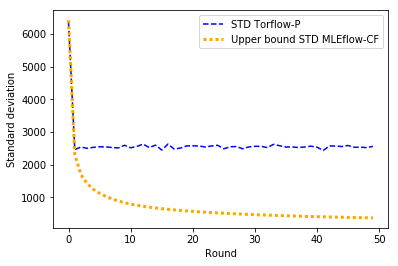

In [27]:
plt.plot(np.sqrt(var_torflow[len(bw)-11])/1000, label='STD Torflow-P', color='b', linestyle='--')
plt.plot(np.sqrt(var_mleq[len(bw)-11])/1000, label='Upper bound STD MLEflow-CF', linestyle=(0,(1,1)), color='orange', linewidth=3)
plt.xlabel('Round')
plt.ylabel('Standard deviation')
plt.legend()

In [28]:
circuit_mleq_onerelay_nn=generate_one_relay(1000000,wmleq_onerelay_nn_50[1])
bandwidth_mleq_onerelay_nn=circ_bws(circuit_mleq_onerelay_nn,bw)

In [72]:
w0=np.zeros(len(bw))
for i in range(len(bw)):
    w0[i]=1/len(bw)
    
wmleq_onerelay_50 =stochasticpoisson_onerelay(1000000,50,w0,Cls,bw, 1, 0.7, 1.3)

In [73]:
error_r_MLEQ=np.zeros(len(bw))
for i in range(len(error_r_MLEQ)):
    error_r_MLEQ[i]=abs(wmleq_onerelay_nn_50[1][i]-c[i])/c[i]*100

In [74]:
error_r_MLEQ_n=np.zeros(len(bw))
for i in range(len(error_r_MLEQ_n)):
    error_r_MLEQ_n[i]=abs(wmleq_onerelay_50[1][i]-c[i])/c[i]*100

In [29]:
def iterativepoisson_onerelay(lambdas,t,w0, bw, noise):
    
    w=np.zeros(len(bw))
    for i in range(len(bw)):
        w[i]=w0[i]
    l=sum(w)
    for i in range(len(w)):
        w[i]=w[i]/l
    
    C=np.zeros(len(bw))
    H=np.zeros(len(bw))
    z=np.zeros(len(bw))
    
    for q in range (t):
        circofone=P_onerelay(w,lambdas)
        if noise==0:
            o=O(circofone,bw)
        else:
            o=O_noise(circofone, bw)
        
        for i in range(len(bw)):
            H[i]=H[i]+(1/o[i])
            C[i]=C[i]+((1/o[i])*math.log(o[i]*lambdas*w[i]))
            z[i]=math.exp(-C[i]/H[i])
            z[i]=((q+1)*z[i])/float(H[i])
            z[i]=np.real(lambertw(z[i]))
            z[i]=(q+1)/(float(H[i])*z[i])
            w[i]=z[i]
            
        l=sum(w)
        for i in range(len(w)):
            w[i]=w[i]/l 
            
    return [w]

In [30]:
w0=np.zeros(len(bw))
for i in range(len(bw)):
    w0[i]=1/len(bw)
    
wmlecf_onerelay_nn_50 =iterativepoisson_onerelay(1000000,50,w0,bw, 0)

In [31]:
circuit_mlecf_onerelay_nn=generate_one_relay(1000000,wmlecf_onerelay_nn_50[0])
bandwidth_mlecf_onerelay_nn=circ_bws(circuit_mlecf_onerelay_nn,bw)

In [32]:
w0=np.zeros(len(bw))
for i in range(len(bw)):
    w0[i]=1/len(bw)
    
wmlecf_onerelay_50 =iterativepoisson_onerelay(1000000,50,w0,bw, 1)

In [33]:
circuit_mlecf_onerelay=generate_one_relay(1000000,wmlecf_onerelay_50[0])
bandwidth_mlecf_onerelay=circ_bws(circuit_mlecf_onerelay,bw)

In [75]:
error_r_MLETS=np.zeros(len(bw))
for i in range(len(error_r_MLETS)):
    error_r_MLETS[i]=abs(wmlecf_onerelay_nn_50[0][i]-c[i])/c[i]*100

In [76]:
error_r_MLETS_n=np.zeros(len(bw))
for i in range(len(error_r_MLETS_n)):
    error_r_MLETS_n[i]=abs(wmlecf_onerelay_50[0][i]-c[i])/c[i]*100

In [36]:
def sbws_onerelay(lambdas,t,w0, bw, noise):
    C=np.zeros(len(bw))
    w=np.zeros(len(bw))
    
    for i in range(len(bw)):
        w[i]=w0[i]
        C[i]=w0[i]
    l=sum(w)
    for i in range(len(w)):
        w[i]=w[i]/l
    
    for q in range (t):
        circofone=P_onerelay(w,lambdas)
        if noise==0:
            o=O(circofone,bw)
        else:
            o=O_noise(circofone,bw)
        av=sum(o)/len(o)
        for i in range(len(bw)):
            if C[i]<bw[i]:
                C[i]=C[i] * o[i] / av
            else:
                C[i]=bw[i] * o[i] / av
        l=sum(C)
        for i in range(len(bw)):
            w[i]=C[i]/l
        
    return [w, C]

In [37]:
w0=np.zeros(len(bw))
for i in range(len(bw)):
    w0[i]=12000
    
wsbws_onerelay_50_nn=sbws_onerelay(1000000,50,w0,bw, 0)

In [40]:
circuit_sbws_onerelay_nn=generate_one_relay(1000000,wsbws_onerelay_50_nn[0])
bandwidth_sbws_onerelay_nn=circ_bws(circuit_sbws_onerelay_nn,bw)

In [41]:
w0=np.zeros(len(bw))
for i in range(len(bw)):
    w0[i]=12000
    
wsbws_onerelay_50=sbws_onerelay(1000000,50,w0,bw, 1)

In [42]:
circuit_sbws_onerelay=generate_one_relay(1000000,wsbws_onerelay_50[0])
bandwidth_sbws_onerelay=circ_bws(circuit_sbws_onerelay,bw)

In [77]:
error_r_sbws=np.zeros(len(bw))
for i in range(len(error_r_sbws)):
    error_r_sbws[i]=abs(wsbws_onerelay_50_nn[0][i]-c[i])/c[i]*100

In [78]:
error_r_sbws_n=np.zeros(len(bw))
for i in range(len(error_r_sbws_n)):
    error_r_sbws_n[i]=abs(wsbws_onerelay_50[0][i]-c[i])/c[i]*100

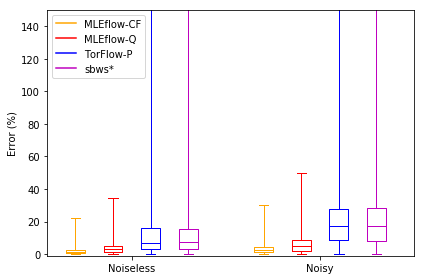

In [79]:
data_a = [error_r_MLETS, error_r_MLETS_n]
data_b = [error_r_MLEQ, error_r_MLEQ_n]
data_c = [error_r_tor, error_r_tor_n]
data_d = [error_r_sbws, error_r_sbws_n]

ticks = ['Noiseless', 'Noisy']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bpl = plt.boxplot(data_a,whis='range', positions=np.array(range(len(data_a)))*2.0-0.6, sym='', widths=0.2)
bpc = plt.boxplot(data_b,whis='range', positions=np.array(range(len(data_b)))*2.0-0.2, sym='', widths=0.2)
bpr = plt.boxplot(data_c,whis='range', positions=np.array(range(len(data_c)))*2.0+0.2, sym='', widths=0.2)
bpr2 = plt.boxplot(data_d,whis='range', positions=np.array(range(len(data_d)))*2.0+0.6, sym='', widths=0.2)

set_box_color(bpl, 'orange') # colors are from http://colorbrewer2.org/
set_box_color(bpc, 'r')
set_box_color(bpr, 'b')
set_box_color(bpr2, 'm')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='orange', label='MLEflow-CF')
plt.plot([], c='r', label='MLEflow-Q')
plt.plot([], c='b', label='TorFlow-P')
plt.plot([], c='m', label='sbws*')
plt.ylabel('Error (%)')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-0.9, len(ticks)*1.5)
plt.ylim(-1, 150)
plt.tight_layout()

In [43]:
def torflow (lambdas,t,w0, bw, bwguard, bwmiddle, bwexit, noise):
    
    Cguard=np.zeros(len(bwguard))
    Cmiddle=np.zeros(len(bwmiddle))
    Cexit=np.zeros(len(bwexit))
    
    
    wguard=np.zeros(len(bwguard))
    for i in range(len(bwguard)):
        wguard[i]=w0[i]
    l=sum(wguard)
    for i in range(len(wguard)):
        wguard[i]=wguard[i]/l
    
  
    
    #the actual weights of middle relays
    
    wmiddle2=np.zeros(len(bwguard)+len(bwmiddle))
    for i in range(len(bwguard)):
        wmiddle2[i]=0.41*w0[i]
    for i in range(len(bwmiddle)):
        wmiddle2[i+len(bwguard)]=w0[i+len(bwguard)]
    l=sum(wmiddle2)
    for i in range(len(wmiddle2)):
        wmiddle2[i]=wmiddle2[i]/l
    
    
    wexit=np.zeros(len(bwexit))   
    for i in range(len(bwexit)):
        wexit[i]=w0[i+len(bwguard)+len(bwmiddle)]
    l=sum(wexit)
    for i in range(len(wexit)):
        wexit[i]=wexit[i]/l   
    
    
    for q in range (t):
        circofone=P_threerelays(wguard,wmiddle2,wexit,lambdas)
        if noise==0:
            [o_guard, o_mid, o_ex]=Ospec(circofone,bw, bwguard, bwmiddle, bwexit)
        else:
            [o_guard, o_mid, o_ex]=Ospec_noise(circofone,bw, bwguard, bwmiddle, bwexit)
        av=sum(o_ex)/len(o_ex)
        for i in range(len(bwexit)):
            wexit[i]=wexit[i] * o_ex[i] / av
        l=sum(wexit)
        for i in range(len(bwexit)):
            wexit[i]=wexit[i]/l
        
        av=sum(o_guard)/len(o_guard)
        for i in range(len(bwguard)):
            wmiddle2[i]=0.41*wguard[i] * o_guard[i] / av
            wguard[i]=wguard[i] * o_guard[i] / av
        l=sum(wguard)
        for i in range(len(bwguard)):
            wguard[i]=wguard[i]/l
            
        av=sum(o_mid)/len(o_mid)
        for i in range(len(bwmiddle)):
            wmiddle2[i+len(bwguard)]=wmiddle2[i+len(bwguard)] * o_mid[i] / av
        l=sum(wmiddle2)
        for i in range(len(wmiddle2)):
            wmiddle2[i]=wmiddle2[i]/l
       
    return [wguard, wmiddle2, wexit]

In [44]:
w0=np.zeros(len(bw))
for i in range(len(bw)):
    w0[i]=1/len(bw)
    
wtorflow_50_nn =torflow(1000000,50,w0,bw, bwguard, bwmiddle, bwexit,0)

In [45]:
circuit_torflow_nn=generate(1000000,wtorflow_50_nn[0], wtorflow_50_nn[1], wtorflow_50_nn[2])
bandwidth_torflow_nn=circ_bws(circuit_torflow_nn,bw)

In [46]:
w0=np.zeros(len(bw))
for i in range(len(bw)):
    w0[i]=1/len(bw)
    
wtorflow_50 =torflow(1000000,50,w0,bw, bwguard, bwmiddle, bwexit,1)

In [47]:
circuit_torflow=generate(1000000,wtorflow_50[0], wtorflow_50[1], wtorflow_50[2])
bandwidth_torflow=circ_bws(circuit_torflow,bw)

In [80]:
error_G_tor=np.zeros(len(bwguard))
for i in range(len(error_G_tor)):
    error_G_tor[i]=abs(wtorflow_50_nn[0][i]-cguard[i])/cguard[i]*100
    
error_M_tor=np.zeros(len(bwmiddle))
for i in range(len(error_M_tor)):
    error_M_tor[i]=abs(wtorflow_50_nn[1][len(bwguard)+i]-cmiddle2[len(bwguard)+i])/cmiddle2[len(bwguard)+i]*100

error_E_tor=np.zeros(len(bwexit))
for i in range(len(error_E_tor)):
    error_E_tor[i]=abs(wtorflow_50_nn[2][i]-cexit[i])/cexit[i]*100

In [81]:
error_G_tor_n=np.zeros(len(bwguard))
for i in range(len(error_G_tor_n)):
    error_G_tor_n[i]=abs(wtorflow_50[0][i]-cguard[i])/cguard[i]*100
    
error_M_tor_n=np.zeros(len(bwmiddle))
for i in range(len(error_M_tor_n)):
    error_M_tor_n[i]=abs(wtorflow_50[1][len(bwguard)+i]-cmiddle2[len(bwguard)+i])/cmiddle2[len(bwguard)+i]*100

error_E_tor_n=np.zeros(len(bwexit))
for i in range(len(error_E_tor_n)):
    error_E_tor_n[i]=abs(wtorflow_50[2][i]-cexit[i])/cexit[i]*100

In [51]:
def stochasticpoisson(lambdas,t,w0,cqm, bw,bwguard, bwmiddle, bwexit, noise, min_noise, max_noise):    
    
    LF=logfac(lambdas)
    
    Logm_guard=np.zeros((len(bwguard), len(cqm)))
    Cguard=np.zeros(len(bwguard))
    
    Logm_mid=np.zeros((len(bwmiddle), len(cqm)))
    Cmiddle=np.zeros(len(bwmiddle))
    
    Logm_ex=np.zeros((len(bwexit), len(cqm)))
    Cexit=np.zeros(len(bwexit))
    
  
    wguard=np.zeros(len(bwguard))
    for i in range(len(bwguard)):
        wguard[i]=w0[i]
    l=sum(wguard)
    for i in range(len(wguard)):
        wguard[i]=wguard[i]/l
    
  
    
    #the actual weights of middle relays
    
    wmiddle2=np.zeros(len(bwguard)+len(bwmiddle))
    for i in range(len(bwguard)):
        wmiddle2[i]=0.42*w0[i]
    for i in range(len(bwmiddle)):
        wmiddle2[i+len(bwguard)]=w0[i+len(bwguard)]
    l=sum(wmiddle2)
    for i in range(len(wmiddle2)):
        wmiddle2[i]=wmiddle2[i]/l
    
    
    wexit=np.zeros(len(bwexit))   
    for i in range(len(bwexit)):
        wexit[i]=w0[i+len(bwguard)+len(bwmiddle)]
    l=sum(wexit)
    for i in range(len(wexit)):
        wexit[i]=wexit[i]/l   
    
    
    for q in range (t):
        circofone=P_threerelays(wguard,wmiddle2,wexit,lambdas)
        if noise==0:
            [o_guard, o_mid, o_ex]=Ospec(circofone,bw, bwguard, bwmiddle, bwexit)


            #sum of log for entry/middle relays
            for i in range(len(bwguard)):
                for j in range(len(cqm)):
                    x0=(round((cqm[j]/o_guard[i])-1))
                    if (x0<0) or (x0>lambdas):
                        Logm_guard[i][j]=-math.inf
                    else:
                        x0=int(x0)
                        if Logm_guard[i][j]!= -math.inf:
                            Logm_guard[i][j]=Logm_guard[i][j]-lambdas*wguard[i]-LF[x0]+x0*math.log(lambdas*wguard[i])
                Cguard[i]=cqm[np.argmax(Logm_guard[i])]


            #sum of logs for middle relays    
            for i in range(len(bwmiddle)):
                for j in range(len(cqm)):
                    x0=(round((cqm[j]/o_mid[i])-1))
                    if (x0<0) or (x0>lambdas):
                        Logm_mid[i][j]=-math.inf
                    else:
                        x0=int(x0)
                        if Logm_mid[i][j]!= -math.inf:
                            Logm_mid[i][j]=Logm_mid[i][j]-lambdas*wmiddle2[i+len(bwguard)]-LF[x0]+x0*math.log(lambdas*wmiddle2[i+len(bwguard)])
                Cmiddle[i]=cqm[np.argmax(Logm_mid[i])]



            #sum of log for exit/middle relays
            for i in range(len(bwexit)):
                for j in range(len(cqm)):
                    x0=(round((cqm[j]/o_ex[i])-1))
                    if (x0<0) or (x0>lambdas):
                        Logm_ex[i][j]=-math.inf
                    else:
                        x0=int(x0)
                        if Logm_ex[i][j]!= -math.inf:
                            Logm_ex[i][j]=Logm_ex[i][j]-lambdas*wexit[i]-LF[x0]+x0*math.log(lambdas*wexit[i])
                Cexit[i]=cqm[np.argmax(Logm_ex[i])]
        else:
            [o_guard, o_mid, o_ex]=Ospec_noise(circofone,bw, bwguard, bwmiddle, bwexit)


            for i in range(len(bwguard)):
                xmax=np.zeros(len(cqm))
                xmin=np.zeros(len(cqm))
                for j in range(len(cqm)):
                    xmax[j]=int(round(max_noise*cqm[j]/o_guard[i]-1))
                    xmin[j]=int(round(min_noise*cqm[j]/o_guard[i]-1))
                    if xmax[j]>lambdas:
                        xmax[j]=lambdas
                    if xmin[j]<0: 
                        xmin[j]=0
                    if xmin[j]>lambdas:
                        xmax[j]=-1
                M=int(max(xmax))
                a=int(math.floor(M))
                B=np.array([-lambdas*wguard[i]+x*math.log(lambdas*wguard[i])-LF[x] for x in range(a+1)])
                Q=np.array([o_guard[i]*(x+1) for x in range(a+1)])
                for j in range(len(cqm)):
                    if xmax[j]>=0:
                        #v=int(math.floor(xmax[j]/5))+1
                        v=int(math.floor(xmax[j]))+1
                        u=int(math.ceil(xmin[j]))
                        L=logsumcal(cqm[j],B[u:v],Q[u:v])
                        Logm_guard[i][j]=Logm_guard[i][j]+L
                    else:
                        Logm_guard[i][j]=-math.inf
                Cguard[i]=cqm[np.argmax(Logm_guard[i])]


            for i in range(len(bwmiddle)):
                xmax=np.zeros(len(cqm))
                xmin=np.zeros(len(cqm))
                for j in range(len(cqm)):
                    xmax[j]=int(round(max_noise*cqm[j]/o_mid[i]-1))
                    xmin[j]=int(round(min_noise*cqm[j]/o_mid[i]-1))
                    if xmax[j]>lambdas:
                        xmax[j]=lambdas
                    if xmin[j]<0: 
                        xmin[j]=0
                    if xmin[j]>lambdas:
                        xmax[j]=-1
                M=int(max(xmax))
                a=int(math.floor(M))
                B=np.array([-lambdas*wmiddle2[i+len(bwguard)]+x*math.log(lambdas*wmiddle2[i+len(bwguard)])-LF[x] for x in range(a+1)])
                Q=np.array([o_mid[i]*(x+1) for x in range(a+1)])
                for j in range(len(cqm)):
                    if xmax[j]>=0:
                        #v=int(math.floor(xmax[j]/5))+1
                        v=int(math.floor(xmax[j]))+1
                        u=int(math.ceil(xmin[j]))
                        L=logsumcal(cqm[j],B[u:v],Q[u:v])
                        Logm_mid[i][j]=Logm_mid[i][j]+L
                    else:
                        Logm_mid[i][j]=-math.inf
                Cmiddle[i]=cqm[np.argmax(Logm_mid[i])]


            for i in range(len(bwexit)):
                xmax=np.zeros(len(cqm))
                xmin=np.zeros(len(cqm))
                for j in range(len(cqm)):
                    xmax[j]=int(round(max_noise*cqm[j]/o_ex[i]-1))
                    xmin[j]=int(round(min_noise*cqm[j]/o_ex[i]-1))
                    if xmax[j]>lambdas:
                        xmax[j]=lambdas
                    if xmin[j]<0: 
                        xmin[j]=0
                    if xmin[j]>lambdas:
                        xmax[j]=-1
                M=int(max(xmax))
                a=int(math.floor(M))
                B=np.array([-lambdas*wexit[i]+x*math.log(lambdas*wexit[i])-LF[x] for x in range(a+1)])
                Q=np.array([o_ex[i]*(x+1) for x in range(a+1)])
                for j in range(len(cqm)):
                    if xmax[j]>=0:
                        #v=int(math.floor(xmax[j]/5))+1
                        v=int(math.floor(xmax[j]))+1
                        u=int(math.ceil(xmin[j]))
                        L=logsumcal(cqm[j],B[u:v],Q[u:v])
                        Logm_ex[i][j]=Logm_ex[i][j]+L
                    else:
                        Logm_ex[i][j]=-math.inf
                Cexit[i]=cqm[np.argmax(Logm_ex[i])]
            
            
        
        for i in range(len(bwguard)):
            wguard[i]=Cguard[i]
        l=sum(wguard)
        for i in range(len(wguard)):
            wguard[i]=wguard[i]/l

            
        
        for i in range(len(bwguard)):
            wmiddle2[i]=0.42*Cguard[i]
        for i in range(len(bwmiddle)):
            wmiddle2[i+len(bwguard)]=Cmiddle[i]
        l=sum(wmiddle2)
        for i in range(len(wmiddle2)):
            wmiddle2[i]=wmiddle2[i]/l

       
        for i in range(len(bwexit)):
            wexit[i]=Cexit[i]
        l=sum(wexit)
        for i in range(len(wexit)):
            wexit[i]=wexit[i]/l   

    return [Cguard, Cmiddle, Cexit,  wguard, wmiddle2, wexit]

In [52]:
w0=np.zeros(len(bw))
for i in range(len(bw)):
    w0[i]=1/len(bw)
    
wmleq_50_nn =stochasticpoisson(1000000,50,w0,Cls,bw, bwguard, bwmiddle, bwexit, 0, 0, 0)

In [53]:
circuit_mleq_nn=generate(1000000,wmleq_50_nn[3], wmleq_50_nn[4], wmleq_50_nn[5])
bandwidth_mleq_nn=circ_bws(circuit_mleq_nn,bw)

In [54]:
w0=np.zeros(len(bw))
for i in range(len(bw)):
    w0[i]=1/len(bw)
    
wmleq_50 =stochasticpoisson(1000000,50,w0,Cls,bw, bwguard, bwmiddle, bwexit, 1, 0.7, 1.3)

In [55]:
circuit_mleq=generate(1000000,wmleq_50[3], wmleq_50[4], wmleq_50[5])
bandwidth_mleq=circ_bws(circuit_mleq,bw)

In [82]:
error_G_MLEQ=np.zeros(len(bwguard))
for i in range(len(error_G_MLEQ)):
    error_G_MLEQ[i]=abs(wmleq_50_nn[3][i]-cguard[i])/cguard[i]*100
    
error_M_MLEQ=np.zeros(len(bwmiddle))
for i in range(len(error_M_MLEQ)):
    error_M_MLEQ[i]=abs(wmleq_50_nn[4][len(bwguard)+i]-cmiddle2[len(bwguard)+i])/cmiddle2[len(bwguard)+i]*100

error_E_MLEQ=np.zeros(len(bwexit))
for i in range(len(error_E_MLEQ)):
    error_E_MLEQ[i]=abs(wmleq_50_nn[5][i]-cexit[i])/cexit[i]*100

In [83]:
error_G_MLEQ_n=np.zeros(len(bwguard))
for i in range(len(error_G_MLEQ_n)):
    error_G_MLEQ_n[i]=abs(wmleq_50[3][i]-cguard[i])/cguard[i]*100
    
error_M_MLEQ_n=np.zeros(len(bwmiddle))
for i in range(len(error_M_MLEQ_n)):
    error_M_MLEQ_n[i]=abs(wmleq_50[4][len(bwguard)+i]-cmiddle2[len(bwguard)+i])/cmiddle2[len(bwguard)+i]*100

error_E_MLEQ_n=np.zeros(len(bwexit))
for i in range(len(error_E_MLEQ_n)):
    error_E_MLEQ_n[i]=abs(wmleq_50[5][i]-cexit[i])/cexit[i]*100

In [60]:
def iterativepoisson(lambdas,t,w0, bw, bwguard, bwmiddle, bwexit,noise):
    
    wguard=np.zeros(len(bwguard))
    for i in range(len(bwguard)):
        wguard[i]=w0[i]
    l=sum(wguard)
    for i in range(len(wguard)):
        wguard[i]=wguard[i]/l
    
  
    
    #the actual weights of middle relays
    
    wmiddle2=np.zeros(len(bwguard)+len(bwmiddle))
    for i in range(len(bwguard)):
        wmiddle2[i]=0.41*w0[i]
    for i in range(len(bwmiddle)):
        wmiddle2[i+len(bwguard)]=w0[i+len(bwguard)]
    l=sum(wmiddle2)
    for i in range(len(wmiddle2)):
        wmiddle2[i]=wmiddle2[i]/l
    
    
    wexit=np.zeros(len(bwexit))   
    for i in range(len(bwexit)):
        wexit[i]=w0[i+len(bwguard)+len(bwmiddle)]
    l=sum(wexit)
    for i in range(len(wexit)):
        wexit[i]=wexit[i]/l   
    
    
    Cguard=np.zeros(len(bwguard))
    Hguard=np.zeros(len(bwguard))
    zguard=np.zeros(len(bwguard))
    
    Cmiddle=np.zeros(len(bwmiddle))
    Hmiddle=np.zeros(len(bwmiddle))
    zmiddle=np.zeros(len(bwmiddle))
    
    Cexit=np.zeros(len(bwexit))
    Hexit=np.zeros(len(bwexit))
    zexit=np.zeros(len(bwexit))
    
    for q in range (t):
        circofone=P_threerelays(wguard,wmiddle2,wexit,lambdas)
        if noise==0:
            [o_guard, o_mid, o_ex]=Ospec(circofone,bw, bwguard, bwmiddle, bwexit)
        else:
            [o_guard, o_mid, o_ex]=Ospec_noise(circofone,bw, bwguard, bwmiddle, bwexit)
        
        for i in range(len(bwguard)):
            Hguard[i]=Hguard[i]+(1/o_guard[i])
            Cguard[i]=Cguard[i]+((1/o_guard[i])*math.log(o_guard[i]*lambdas*wguard[i]))
            zguard[i]=math.exp(-Cguard[i]/Hguard[i])
            zguard[i]=((q+1)*zguard[i])/float(Hguard[i])
            zguard[i]=np.real(lambertw(zguard[i]))
            zguard[i]=(q+1)/(float(Hguard[i])*zguard[i])
            wguard[i]=zguard[i]
            wmiddle2[i]=0.41*zguard[i]
        l=sum(wguard)
        for i in range(len(wguard)):
            wguard[i]=wguard[i]/l
            
        for i in range(len(bwmiddle)):
            Hmiddle[i]=Hmiddle[i]+(1/o_mid[i])
            Cmiddle[i]=Cmiddle[i]+((1/o_mid[i])*math.log(o_mid[i]*lambdas*wmiddle2[i+len(bwguard)]))
            zmiddle[i]=math.exp(-Cmiddle[i]/Hmiddle[i])
            zmiddle[i]=((q+1)*zmiddle[i])/float(Hmiddle[i])
            zmiddle[i]=np.real(lambertw(zmiddle[i]))
            zmiddle[i]=(q+1)/(float(Hmiddle[i])*zmiddle[i])
            wmiddle2[i+len(bwguard)]=zmiddle[i]
        l=sum(wmiddle2)
        for i in range(len(wmiddle2)):
            wmiddle2[i]=wmiddle2[i]/l
        
        
        for i in range(len(bwexit)):
            Hexit[i]=Hexit[i]+(1/o_ex[i])
            Cexit[i]=Cexit[i]+((1/o_ex[i])*math.log(o_ex[i]*lambdas*wexit[i]))
            zexit[i]=math.exp(-Cexit[i]/Hexit[i])
            zexit[i]=((q+1)*zexit[i])/float(Hexit[i])
            zexit[i]=np.real(lambertw(zexit[i]))
            zexit[i]=(q+1)/(float(Hexit[i])*zexit[i])
            wexit[i]=zexit[i]
        l=sum(wexit)
        for i in range(len(wexit)):
            wexit[i]=wexit[i]/l
            
            
    return [wguard, wmiddle2, wexit]

In [61]:
w0=np.zeros(len(bw))
for i in range(len(bw)):
    w0[i]=1/len(bw)
    
wmlecf_50_nn =iterativepoisson(1000000,50,w0,bw, bwguard, bwmiddle, bwexit, 0)

In [62]:
circuit_mlecf_nn=generate(1000000,wmlecf_50_nn[0], wmlecf_50_nn[1], wmlecf_50_nn[2])
bandwidth_mlecf_nn=circ_bws(circuit_mlecf_nn,bw)

In [63]:
w0=np.zeros(len(bw))
for i in range(len(bw)):
    w0[i]=1/len(bw)
    
wmlecf_50 =iterativepoisson(1000000,50,w0,bw, bwguard, bwmiddle, bwexit, 1)

In [64]:
circuit_mlecf=generate(1000000,wmlecf_50[0], wmlecf_50[1], wmlecf_50[2])
bandwidth_mlecf=circ_bws(circuit_mlecf,bw)

In [84]:
error_G_MLETS=np.zeros(len(bwguard))
for i in range(len(error_G_MLETS)):
    error_G_MLETS[i]=abs(wmlecf_50_nn[0][i]-cguard[i])/cguard[i]*100
    
error_M_MLETS=np.zeros(len(bwmiddle))
for i in range(len(error_M_MLETS)):
    error_M_MLETS[i]=abs(wmlecf_50_nn[1][len(bwguard)+i]-cmiddle2[len(bwguard)+i])/cmiddle2[len(bwguard)+i]*100

error_E_MLETS=np.zeros(len(bwexit))
for i in range(len(error_E_MLETS)):
    error_E_MLETS[i]=abs(wmlecf_50_nn [2][i]-cexit[i])/cexit[i]*100

In [85]:
error_G_MLETS_n=np.zeros(len(bwguard))
for i in range(len(error_G_MLETS_n)):
    error_G_MLETS_n[i]=abs(wmlecf_50[0][i]-cguard[i])/cguard[i]*100
    
error_M_MLETS_n=np.zeros(len(bwmiddle))
for i in range(len(error_M_MLETS_n)):
    error_M_MLETS_n[i]=abs(wmlecf_50[1][len(bwguard)+i]-cmiddle2[len(bwguard)+i])/cmiddle2[len(bwguard)+i]*100

error_E_MLETS_n=np.zeros(len(bwexit))
for i in range(len(error_E_MLETS_n)):
    error_E_MLETS_n[i]=abs(wmlecf_50[2][i]-cexit[i])/cexit[i]*100

In [65]:
def sbws(lambdas,t,C0, bw, bwguard, bwmiddle, bwexit, noise):

    
    Cguard=np.zeros(len(bwguard))
    wguard=np.zeros(len(bwguard))
    for i in range(len(bwguard)):
        wguard[i]=C0[i]
        Cguard[i]=C0[i]
    l=sum(wguard)
    for i in range(len(wguard)):
        wguard[i]=wguard[i]/l
    

    Cmiddle2=np.zeros(len(bwguard)+len(bwmiddle))
    wmiddle2=np.zeros(len(bwguard)+len(bwmiddle))
    for i in range(len(bwguard)):
        wmiddle2[i]=0.41*C0[i]
        Cmiddle2[i]=0.41*C0[i]
    for i in range(len(bwmiddle)):
        wmiddle2[i+len(bwguard)]=C0[i+len(bwguard)]
        Cmiddle2[i+len(bwguard)]=C0[i+len(bwguard)]
    l=sum(wmiddle2)
    for i in range(len(wmiddle2)):
        wmiddle2[i]=wmiddle2[i]/l
    
    
    Cexit=np.zeros(len(bwexit))
    wexit=np.zeros(len(bwexit))   
    for i in range(len(bwexit)):
        wexit[i]=C0[i+len(bwguard)+len(bwmiddle)]
        Cexit[i]=C0[i+len(bwguard)+len(bwmiddle)]
    l=sum(wexit)
    for i in range(len(wexit)):
        wexit[i]=wexit[i]/l   
    
    
    for q in range (t):
        circofone=P_threerelays(wguard,wmiddle2,wexit,lambdas)
        if noise==0:
            [o_guard, o_mid, o_ex]=Ospec(circofone,bw, bwguard, bwmiddle, bwexit)
        else:
            [o_guard, o_mid, o_ex]=Ospec_noise(circofone,bw, bwguard, bwmiddle, bwexit)
        
        
        av=sum(o_ex)/len(o_ex)
        for i in range(len(bwexit)):
            if Cexit[i]<bwexit[i]:
                Cexit[i]=Cexit[i] * o_ex[i] / av
            else:
                Cexit[i]=bwexit[i] * o_ex[i] / av
        l=sum(Cexit)
        for i in range(len(bwexit)):
            wexit[i]=Cexit[i]/l
        
        
        av=sum(o_guard)/len(o_guard)
        for i in range(len(bwguard)):
            if Cguard[i]<bwguard[i]:
                Cguard[i]=Cguard[i] * o_guard[i] / av
            else:
                Cguard[i]=bwguard[i] * o_guard[i] / av
        l=sum(Cguard)
        for i in range(len(bwguard)):
            wguard[i]=Cguard[i]/l
            
        av=sum(o_guard)/len(o_guard)
        for i in range(len(bwguard)):
            if Cmiddle2[i]<0.41*bwguard[i]:
                Cmiddle2[i]=Cmiddle2[i] * o_guard[i] / av
            else:
                Cmiddle2[i]=0.41*bwguard[i] * o_guard[i] / av
        
        av=sum(o_mid)/len(o_mid)
        for i in range(len(bwmiddle)):
            if Cmiddle2[i+len(bwguard)]<bwmiddle[i]:
                Cmiddle2[i+len(bwguard)]=Cmiddle2[i+len(bwguard)] * o_mid[i] / av
            else:
                Cmiddle2[i+len(bwguard)]=bwmiddle[i] * o_mid[i] / av
        l=sum(Cmiddle2)
        for i in range(len(wmiddle2)):
            wmiddle2[i]=Cmiddle2[i]/l

    return [Cguard, Cmiddle2, Cexit, wguard, wmiddle2, wexit]

In [66]:
w0=np.zeros(len(bw))
for i in range(len(w0)):
    w0[i]=120000


wsbws_50_nn=sbws(1000000,50,w0,bw, bwguard, bwmiddle, bwexit,0)

In [67]:
circuit_sbws_nn=generate(1000000,wsbws_50_nn[3], wsbws_50_nn[4], wsbws_50_nn[5])
bandwidth_sbws_nn=circ_bws(circuit_sbws_nn,bw)

In [68]:
w0=np.zeros(len(bw))
for i in range(len(w0)):
    w0[i]=120000


wsbws_50=sbws(1000000,50,w0,bw, bwguard, bwmiddle, bwexit,1)

In [ ]:
circuit_sbws=generate(1000000,wsbws_50[3], wsbws_50[4], wsbws_50[5])
bandwidth_sbws=circ_bws(circuit_sbws,bw)

In [86]:
error_G_sbws=np.zeros(len(bwguard))
for i in range(len(error_G_tor)):
    error_G_sbws[i]=abs(wsbws_50_nn[3][i]-cguard[i])/cguard[i]*100
    
error_M_sbws=np.zeros(len(bwmiddle))
for i in range(len(error_M_tor)):
    error_M_sbws[i]=abs(wsbws_50_nn[4][len(bwguard)+i]-cmiddle2[len(bwguard)+i])/cmiddle2[len(bwguard)+i]*100

error_E_sbws=np.zeros(len(bwexit))
for i in range(len(error_E_tor)):
    error_E_sbws[i]=abs(wsbws_50_nn[5][i]-cexit[i])/cexit[i]*100

In [87]:
error_G_sbws_n=np.zeros(len(bwguard))
for i in range(len(error_G_sbws_n)):
    error_G_sbws_n[i]=abs(wsbws_50[3][i]-cguard[i])/cguard[i]*100
    
error_M_sbws_n=np.zeros(len(bwmiddle))
for i in range(len(error_M_sbws_n)):
    error_M_sbws_n[i]=abs(wsbws_50[4][len(bwguard)+i]-cmiddle2[len(bwguard)+i])/cmiddle2[len(bwguard)+i]*100

error_E_sbws_n=np.zeros(len(bwexit))
for i in range(len(error_E_sbws_n)):
    error_E_sbws_n[i]=abs(wsbws_50[5][i]-cexit[i])/cexit[i]*100

/home/nikita/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


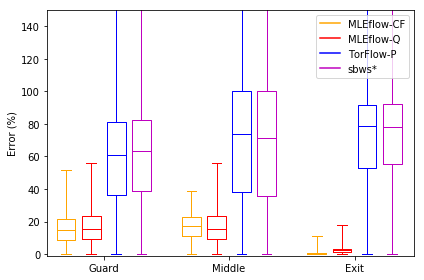

In [88]:
data_a = [error_G_MLETS, error_M_MLETS, error_E_MLETS]
data_b = [error_G_MLEQ, error_G_MLEQ, error_E_MLEQ]
data_c = [error_G_tor, error_M_tor, error_E_tor]
data_d = [error_G_sbws, error_M_sbws, error_E_sbws]

ticks = ['Guard', 'Middle', 'Exit']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bpl = plt.boxplot(data_a,whis='range', positions=np.array(range(len(data_a)))*2.0-0.6, sym='', widths=0.3)
bpc = plt.boxplot(data_b,whis='range', positions=np.array(range(len(data_b)))*2.0-0.2, sym='', widths=0.3)
bpr = plt.boxplot(data_c,whis='range', positions=np.array(range(len(data_c)))*2.0+0.2, sym='', widths=0.3)
bpr2 = plt.boxplot(data_d,whis='range', positions=np.array(range(len(data_d)))*2.0+0.6, sym='', widths=0.3)
set_box_color(bpl, 'orange') # colors are from http://colorbrewer2.org/
set_box_color(bpc, 'r')
set_box_color(bpr, 'b')
set_box_color(bpr2, 'm')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='orange', label='MLEflow-CF')
plt.plot([], c='r', label='MLEflow-Q')
plt.plot([], c='b', label='TorFlow-P')
plt.plot([], c='m', label='sbws*')
plt.ylabel('Error (%)')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-0.9, len(ticks)*1.65)
plt.ylim(-1, 150)
plt.tight_layout()

/home/nikita/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


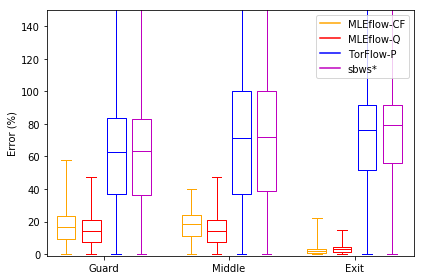

In [89]:
data_a = [error_G_MLETS_n, error_M_MLETS_n, error_E_MLETS_n]
data_b = [error_G_MLEQ_n, error_G_MLEQ_n, error_E_MLEQ_n]
data_c = [error_G_tor_n, error_M_tor_n, error_E_tor_n]
data_d = [error_G_sbws_n, error_M_sbws_n, error_E_sbws_n]

ticks = ['Guard', 'Middle', 'Exit']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bpl = plt.boxplot(data_a,whis='range', positions=np.array(range(len(data_a)))*2.0-0.6, sym='', widths=0.3)
bpc = plt.boxplot(data_b,whis='range', positions=np.array(range(len(data_b)))*2.0-0.2, sym='', widths=0.3)
bpr = plt.boxplot(data_c,whis='range', positions=np.array(range(len(data_c)))*2.0+0.2, sym='', widths=0.3)
bpr2 = plt.boxplot(data_d,whis='range', positions=np.array(range(len(data_d)))*2.0+0.6, sym='', widths=0.3)
set_box_color(bpl, 'orange') # colors are from http://colorbrewer2.org/
set_box_color(bpc, 'r')
set_box_color(bpr, 'b')
set_box_color(bpr2, 'm')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='orange', label='MLEflow-CF')
plt.plot([], c='r', label='MLEflow-Q')
plt.plot([], c='b', label='TorFlow-P')
plt.plot([], c='m', label='sbws*')
plt.ylabel('Error (%)')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-0.9, len(ticks)*1.65)
plt.ylim(-1, 150)
plt.tight_layout()

In [91]:
circuit_actual=generate(1000000,cguard, cmiddle2, cexit)
bandwidth_actual=circ_bws(circuit_actual,bw)

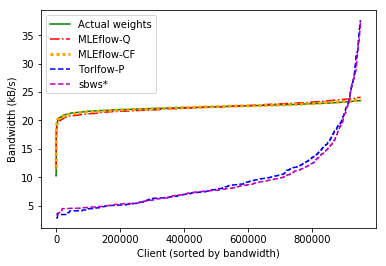

In [92]:
plt.plot(np.array(sorted(bandwidth_actual)[:950000])/1000, label='Actual weights', color='g')
plt.plot(np.array(sorted(bandwidth_mleq_nn)[:950000])/1000, label='MLEflow-Q', linestyle='-.', color='r')
plt.plot(np.array(sorted(bandwidth_mlecf_nn)[:950000])/1000, label='MLEflow-CF', color='orange', linestyle=(0,(1,1)), linewidth=3)
plt.plot(np.array(sorted(bandwidth_torflow_nn)[:950000])/1000, label='Torlfow-P', linestyle='--', color='b')
plt.plot(np.array(sorted(bandwidth_sbws_nn)[:950000])/1000, label='sbws*', linestyle='--', color='m')
plt.xlabel('Client (sorted by bandwidth)')
plt.ylabel('Bandwidth (kB/s)')
plt.legend()

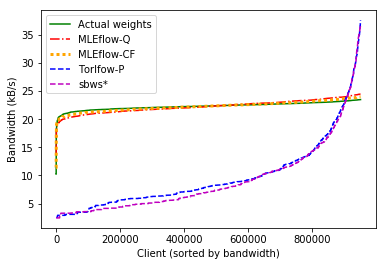

In [93]:
plt.plot(np.array(sorted(bandwidth_actual)[:950000])/1000, label='Actual weights', color='g')
plt.plot(np.array(sorted(bandwidth_mleq)[:950000])/1000, label='MLEflow-Q', linestyle='-.', color='r')
plt.plot(np.array(sorted(bandwidth_mlecf)[:950000])/1000, label='MLEflow-CF', color='orange', linestyle=(0,(1,1)), linewidth=3)
plt.plot(np.array(sorted(bandwidth_torflow)[:950000])/1000, label='Torlfow-P', linestyle='--', color='b')
plt.plot(np.array(sorted(bandwidth_sbws)[:950000])/1000, label='sbws*', linestyle='--', color='m')
plt.xlabel('Client (sorted by bandwidth)')
plt.ylabel('Bandwidth (kB/s)')
plt.legend()